In [19]:
#%%writefile london_hashtags.py
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import os
import pandas as pd
import statsmodels.api as sm
import datetime

class london_hashtags:
    def __init__(self,path,start_date):
        self.minimum_daily_sample_size = 4000 #default sample size cutoff
        
        df = pd.read_csv(path)#,nrows=2000000)
        df['date'] = pd.to_datetime(df['date'])
        
        #include only dates after 'start_date'
        df = df[df['date'] >= start_date]
        self.data = df
        
    def round_dates_to_weekstarting(self):
        def round_dates_to_week_starting_function(df):
            df['date'] = df['date'] - pd.Timedelta('1d') * df['date'].dt.dayofweek
            df['date'] = pd.to_datetime(df['date'].dt.date)
            return df

        return self.data.pipe(round_dates_to_week_starting_function)
        
    def print_summary_stats(self):
        print('# hashtag-days:',len(self.data.index))
        print('date range:',self.data['date'].min(),self.data['date'].max())

        s=self.data.groupby(['hashtag'],as_index=False).agg({'count':'sum'}).sort_values('count',ascending=False)
        s.index=range(1,len(s.index)+1)

        sorted_unique_dates = pd.Series(np.sort(self.data['date'].unique()))

        diff=sorted_unique_dates.diff()
        u=pd.Series(diff.unique()).dropna()
        #only two different gap lengths betwen measurements (1 and 2 days)

        print('maximum number of days between measurements:', u.iloc[1]/u.iloc[0])
        print('number of occassions maximum gap occurs:', len(diff[diff==u.iloc[1]]))

        missing_dates = sorted_unique_dates[np.where(diff==u.iloc[1])[0]]

        #sorted_unique_dates[sorted_unique_dates.isin(missing_dates - pd.Timedelta(1,'d'))]
        print('missing dates are: ', [m - pd.Timedelta(1,'d') for m in missing_dates])
        
        
    def derive_turnover_matrix(self,list_size=100,num_increments=21):
        
        #add list features as attributes
        self.list_size = list_size
        self.num_increments = num_increments
        
        def nlargestGroup(df,list_size):
            return (df.nlargest(list_size,'count').
                    assign(rank = lambda df: df['count'].rank(method='first',ascending = False)))

        def turnover(df):
            return len(df[~df['hashtag_today'].isin(df['hashtag_yesterday'])].index)

        def today_yesterday_merge(df):
            return (df.merge(df, left_on=['date','rank'], right_on=['yesterday','rank'], 
                  suffixes = ('_today','_yesterday'),how='inner'))

        def get_turnover_matrix(df,list_size,num_increments):
            turnover_df = pd.DataFrame()
            
            for ls in np.linspace(1,list_size,num_increments,dtype='int'): 
                turnover_df[ls]=df[df['rank'] <= ls].groupby('date_today').apply(turnover)
            
            return turnover_df
        
        self.turnover_matrix=(
            self.data.groupby('date',as_index=False).apply(nlargestGroup,list_size).
            assign(yesterday = lambda df: df['date']-pd.Timedelta(1,'d')).
            pipe(today_yesterday_merge).
            pipe(get_turnover_matrix,list_size,num_increments)
        ) 
        
        return self.turnover_matrix
    
    def get_daily_sample_size(self): 
        self.daily_sample_size = self.data.groupby('date').agg({'count':'count'})
        return self.daily_sample_size
    
    def get_powerlaw_fit(self): 
        
        #hashtag counts over all dates
        self.all_time_rankings = (self.data.groupby('hashtag').agg({'count':'sum'})['count'].
                                sort_values(ascending = False))
        
        # fit power law 
        self.powerlaw_fit=powerlaw.Fit(self.all_time_rankings,verbose=False)
        self.alpha = self.powerlaw_fit.alpha #power law exponent
        
        return self.all_time_rankings
    
    def get_daily_alpha(self):

        def calculate_daily_powerlaw(df):
            fit=powerlaw.Fit(df['count'],verbose=False)
            return pd.Series([fit.alpha, fit.sigma],index=['alpha','sigma'])

        df2=self.data.groupby('date').apply(calculate_daily_powerlaw)

        self.daily_alpha = df2['alpha']
        self.daily_sigma = df2['sigma'] #also collect the daily statistical errors

        return self.daily_alpha,self.daily_sigma
    
    
    ### indivual methods for the plots ####
    
    def plotaxis_turnover_by_listsize(self,ax):
    
        if hasattr(self,'turnover_matrix') == False:
            #set list size and increments to default
            list_size=100
            num_increments=21
            self.derive_turnover_matrix(list_size,num_increments)


        list_vec = self.turnover_matrix.columns
        mean = self.turnover_matrix.mean()
        error = self.turnover_matrix.std()

        #f, ax = plt.subplots()

        ax.plot(list_vec,mean)
        ax.fill_between(list_vec,mean-error,mean+error,alpha=0.5)
        ax.set_xlabel('list size',fontsize=16)
        ax.set_ylabel('turnover',fontsize=16)

        return ax

    def plotaxis_turnover_by_time(self,ax):

        if hasattr(self,'turnover_matrix') == False:
            #set list size and increments to default
            list_size=100
            num_increments=21
            self.derive_turnover_matrix(list_size,num_increments)

        #HARD WIRED DATE TICKS
        ticks_to_use = pd.Series([pd.to_datetime('2017'),pd.to_datetime('2018'),
                                  pd.to_datetime('2019'),pd.to_datetime('2020')])

        labels = ticks_to_use.dt.year

        ax.plot(self.turnover_matrix[self.list_size],alpha=0.7)

        # Now set the ticks and labels
        ax.set_xticks(self.date_marks)
        ax.set_xticklabels(self.date_labels)

        ax.set_xlabel('year',fontsize=16)
        ax.set_ylabel('turnover (top ' + str(self.list_size) + ')',fontsize=16)

        return ax

    def plotaxis_sample_size(self,ax):

        if hasattr(self,'daily_sample_size') == False:
            self.get_daily_sample_size()
            
            
        ax.plot(self.daily_sample_size.index,self.daily_sample_size,'-')
        ax.set_ylabel('sample size',fontsize=16)
        ax.set_xlabel('year',fontsize=16)
        ax.set_xticks(self.date_marks)
        ax.set_xticklabels(self.date_labels)

        return ax

    def plotaxis_turnover_by_sample_size(self,ax):

        if hasattr(self,'daily_sample_size') == False:
            self.get_daily_sample_size()

        if hasattr(self,'turnover_matrix') == False:
            #set list size and increments to default
            list_size=100
            num_increments=21
            self.derive_turnover_matrix(list_size,num_increments)

        x=self.turnover_matrix[self.list_size]
        y=self.daily_sample_size.loc[self.turnover_matrix.index,'count']

        lowess = sm.nonparametric.lowess(endog=y, exog=x, frac=0.9)    
        xfit,yfit = list(zip(*lowess))

        ax.plot(x,y,'o',alpha=0.7,label='_legend_')
        ax.plot(xfit,yfit,'-',c='darkred',lw=4,alpha=0.7,label='LOESS fit')
        ax.set_ylabel('sample size',fontsize=16)
        ax.set_xlabel('turnover (top 100)',fontsize=16)
        ax.legend(fontsize=14)

        return ax

    def plotaxis_powerlaw(self,ax):

        if hasattr(self,'powerlaw_fit') == False:
            self.get_powerlaw_fit()

        def predicted_y(x,fit):
            yfit = x**-fit.alpha
            yfit = yfit/sum(yfit)
            return yfit

        # power law histogram of hashtags
        x,y = self.powerlaw_fit.pdf()
        x = x[:-1] + np.diff(x)/2
        y = y/sum(y) #normlize probability density

        #power law line of best fit
        yfit = predicted_y(x,self.powerlaw_fit)

        ax.loglog(x,y,'s',lw=3,label='data histogram')
        ax.loglog(x,yfit,'--',lw=2,c='darkred',label=r'power law fit ($\alpha$= ' + str(np.round(self.alpha,2)) + ')')

        ax.set_xlabel('hashtag frequency',fontsize=16)
        ax.set_ylabel('probability',fontsize=16)

        ax.legend(fontsize=14)

        return ax

    def plotaxis_daily_powerlawalpha(self,ax):

        if hasattr(self,'daily_alpha') == False:
            self.get_daily_alpha()


        ax.plot(self.daily_alpha.index,self.daily_alpha,label=r'$\alpha$')
        ax.fill_between(self.daily_alpha.index, 
                        self.daily_alpha-self.daily_sigma, 
                        self.daily_alpha+self.daily_sigma, alpha=0.5,label='std. err.')


        ax.set_xticks(self.date_marks)
        ax.set_xticklabels(self.date_labels)
        ax.set_ylabel(r'$\alpha$',fontsize=20,rotation=0)
        ax.set_xlabel('year',fontsize=16)

        ax.legend(fontsize=14)

        return ax
    
    def summary_plot(self,save_directory):

        plt.style.use('tableau-colorblind10')

        f, ax = plt.subplots(3,2,figsize=[13,9])

        self.plotaxis_turnover_by_listsize(ax[0,0])
        self.plotaxis_turnover_by_time(ax[0,1])
        self.plotaxis_sample_size(ax[1,0])
        self.plotaxis_turnover_by_sample_size(ax[1,1])
        self.plotaxis_powerlaw(ax[2,0])
        self.plotaxis_daily_powerlawalpha(ax[2,1])
        plt.tight_layout()

        if not os.path.exists(save_directory):
            os.makedirs(save_directory)

        plt.savefig(save_directory+'summary_plots.pdf')
        
    ###end plots ######
    
    def date_ticks(self,list_of_years):
        self.date_marks = pd.to_datetime(pd.Series(list_of_years))
        self.date_labels = self.date_marks.dt.year
        
    def remove_low_sample_days(self,dates_to_remove=None):
        
        if dates_to_remove is None:# if no preset dates to remove
            prefiltering_daily_sample_size = self.get_daily_sample_size() 
            dates_to_remove = prefiltering_daily_sample_size[(prefiltering_daily_sample_size < self.minimum_daily_sample_size)['count']].index

        self.data=self.data.drop(self.data[self.data['date'].isin(dates_to_remove)].index)
        
        
    def graphically_choose_new_sample_size_cutoff(self):
        
        prefiltering_daily_sample_size = self.get_daily_sample_size() 

        plt.style.use('tableau-colorblind10')
        f, ax  = plt.subplots()

        ax.plot(prefiltering_daily_sample_size['count'].sort_values().values,'o')
        ax.set_ylabel('sample size',fontsize=16)
        ax.set_xlabel('day rank',fontsize=16)

        ax.set_title('Choose a minimum sample size cutoff?',fontsize=16)
        xy = plt.ginput(1)
        self.minimum_daily_sample_size = xy[0][1]
        print('new minimum sample size:' + str(np.round(self.minimum_daily_sample_size,0)))
        plt.show()
        
    def powerlaw_or_positive_lognormal(self):

        if hasattr(self,'powerlaw_fit') == False:
            self.get_powerlaw_fit()

        dist1='power_law'
        dist2='lognormal_positive'

        R,p = self.powerlaw_fit.distribution_compare(dist1,dist2)

        if R > 0: most_likely_dist = dist1
        if R <= 0: most_likely_dist = dist2

        print('LLR = ' + str(np.round(R,2)) + ', p value = ' + str(np.round(p,2)) + ', most likely distribution is ' + most_likely_dist)

/usr/local/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


LLR = -10.59, p value = 0.36, most likely distribution is lognormal_positive


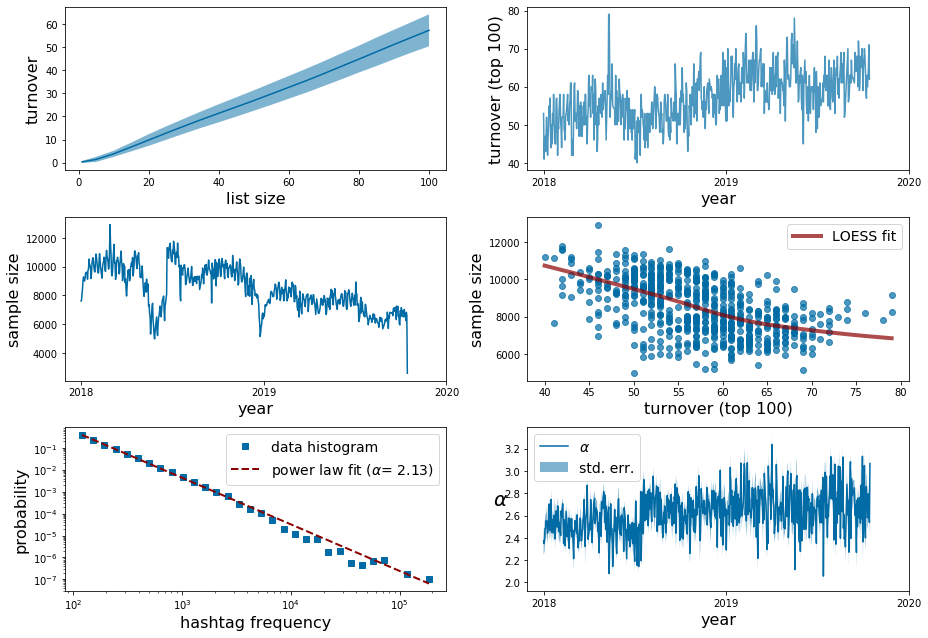

In [20]:
#%%writefile 'run_london_hashtags.py'
#import london_hashtags
import pandas as pd

path = 'data/hashtagCountsPerDayLondon.csv'


start_date = pd.to_datetime('01/01/2018') # effect of changing the sample start day
#self = london_hashtags.london_hashtags(path,start_date)
self = london_hashtags(path,start_date)


list_size=100
num_increments=21

#dates with number of tweets less than 2.5 standard deviations below mean 
dates_to_remove = pd.to_datetime(['2018-05-21', '2018-05-22', '2018-08-09', '2018-11-30','2019-07-11', '2019-08-28', 
                '2019-08-29', '2019-08-31', '2019-09-11', '2019-09-12', '2019-09-13'])

# do you want to remove days with small sample sizes?
#self.graphically_choose_new_sample_size_cutoff()
self.remove_low_sample_days(dates_to_remove)

#is a powerlaw distribution ot lognormal positive the best fit?
self.powerlaw_or_positive_lognormal()

#set x ticks for date axes
list_of_years = ['2018','2019','2020']
self.date_ticks(list_of_years)


## needs to be made more general
#self.print_summary_stats()

turnover = self.derive_turnover_matrix(list_size,num_increments)
Nt = self.get_daily_sample_size()
daily_sample_size=self.get_daily_sample_size()
powerlaw_fit=self.get_powerlaw_fit()
daily_alpha,daily_sigma=self.get_daily_alpha()

self.summary_plot('plots/')



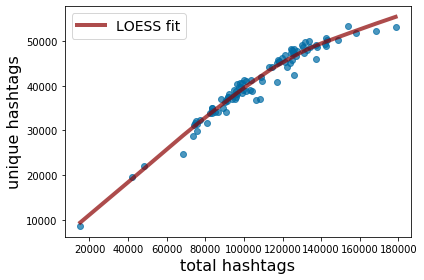

In [28]:

import matplotlib.pyplot as plt
import os

weekly = self.round_dates_to_weekstarting()

df=weekly.groupby('date').agg({'hashtag':'nunique','count':'sum'})#.iloc[:100000]
nu = df['hashtag']
nt = df['count']

lowess = sm.nonparametric.lowess(endog=nu, exog=nt, frac=0.8)    
xfit,yfit = list(zip(*lowess))

plt.style.use('tableau-colorblind10')
f, ax = plt.subplots()

ax.plot(nt,nu,'o',alpha=0.7,label='_legend_')
ax.plot(xfit,yfit,'-',c='darkred',lw=4,alpha=0.7,label='LOESS fit')

ax.set_xlabel('total hashtags',fontsize=16)
ax.set_ylabel('unique hashtags',fontsize=16)

ax.legend(fontsize=14)

plt.tight_layout()

save_directory = 'plots/'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plt.savefig(save_directory+'heaps_law.pdf')
plt.show()

plt.close()

In [247]:
#outlier alpha day, get sample size
outlier_alpha_date = self.daily_alpha.idxmax()
self.daily_sample_size.loc[outlier_alpha_date]


#sample size before and after Jan 1st 2018
s = self.daily_sample_size
s.loc[:pd.to_datetime('2017-12-31')].mean(),s.loc[pd.to_datetime('2017-12-31'):].mean()

(count    13814.435897
 dtype: float64, count    8375.461656
 dtype: float64)